In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os, time, random, keras, pickle, gc

import tensorflow as tf
from keras.utils import plot_model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

from face_verification.facenet import basenet
from face_verification.facenet import triplet_net
from face_verification.facenet import triplet_loss
from face_verification.facenet import train_triplet_generator
from face_verification.facenet import test_triplet_generator

%matplotlib inline

Using TensorFlow backend.


# Load Image Dictionary

In [2]:
vgg2_train = pd.read_csv('./images/vgg2_train_path.csv')
vgg2_test = pd.read_csv('./images/vgg2_test_path.csv')

print('Train:\t# person ={0:5d}\t # images ={1:8d}'.format(len(vgg2_train['name'].unique()), 
                                                           len(vgg2_train)))
print('Test:\t# person ={0:5d}\t # images ={1:8d}'.format(len(vgg2_test['name'].unique()),
                                                          len(vgg2_test)))

vgg2_train.head()

Train:	# person = 8631	 # images = 2113881
Test:	# person =  500	 # images =  116568


,name,path
0,n000002,./images/vgg2_face/train/n000002/0054_01.jpg
1,n000002,./images/vgg2_face/train/n000002/0029_01.jpg
2,n000002,./images/vgg2_face/train/n000002/0202_02.jpg
3,n000002,./images/vgg2_face/train/n000002/0037_01.jpg
4,n000002,./images/vgg2_face/train/n000002/0046_01.jpg


In [3]:
# pre-process the train and test dataframe
def path_to_list(df):
    """ function to merge df into the name and path list format """
    paths = list(df['path'].values)
    count = len(paths)
    
    return pd.Series([count, paths], index=['count', 'paths'])

In [4]:
vgg2_train_df = vgg2_train.groupby('name').apply(path_to_list).reset_index()
vgg2_test_df = vgg2_test.groupby('name').apply(path_to_list).reset_index()

vgg2_train_df.head()

,name,count,paths
0,n000002,198,"[./images/vgg2_face/train/n000002/0054_01.jpg,..."
1,n000003,143,"[./images/vgg2_face/train/n000003/0054_01.jpg,..."
2,n000004,334,"[./images/vgg2_face/train/n000004/0054_01.jpg,..."
3,n000005,67,"[./images/vgg2_face/train/n000005/0430_02.jpg,..."
4,n000006,374,"[./images/vgg2_face/train/n000006/0154_01.jpg,..."


# Define Triplet Network

In [5]:
# For reproduciable purpose
seed = 42
K.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [6]:
# create the base-cnn model
base_model = basenet(output_shape=128)

# # visualization
# plot_model(base_model, show_shapes=True, to_file='./results/base-model.png')
# plot_model(base_model, show_shapes=True, to_file='./results/base-model.pdf')

# base-model summary
base_model.summary()

Instructions for updating:
dim is deprecated, use axis instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 48, 48, 64)   256         conv1[0][0]                      
______________________________________________

In [7]:
# create the triplet-network model
triplet_model = triplet_net(base_model=base_model, input_shape=(96, 96, 3))

# # visualization
# plot_model(triplet_model, show_shapes=True, to_file='./results/triplet-model.png')
# plot_model(triplet_model, show_shapes=True, to_file='./results/triplet-model.pdf')

# base-model summary
triplet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          3743280     anchor_input[0][0]               
                                                                 positive_input[0][0]             
          

# Triplet Network Training

In [8]:
# define learning scheduler
def lr_schedule(epoch):
    """ Learning rate schedule """
    lr = 1e-3
    if epoch > 900:
        lr *= 1e-1
    elif epoch > 800:
        lr *= 2e-1
    elif epoch > 700:
        lr *= 3e-1
    elif epoch > 600:
        lr *= 4e-1
    elif epoch > 500:
        lr *= 5e-1
    elif epoch > 400:
        lr *= 6e-1
    elif epoch > 300:
        lr *= 7e-1
    elif epoch > 200:
        lr *= 8e-1
    elif epoch > 100:
        lr *= 9e-1
        
    return lr

In [9]:
# define optimizer
opt = keras.optimizers.Adam(lr=lr_schedule(0))

# create checkpoint folder
path = './models/margin-01-' + time.strftime('%Y%m%d-%H%M')
if not os.path.exists(path):
    os.mkdir(path)
print('Checkpoing Folder:\t', path)    

# create call backs
checkpoint = ModelCheckpoint(filepath=path + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                             monitor='val_loss', verbose=0, save_best_only=False, 
                             save_weights_only=False, mode='auto', period=10)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# compile the model
triplet_model.compile(optimizer=opt, loss=triplet_loss(0.1))

# define training and test dataset image generator
train_generator = train_triplet_generator(vgg2_train_df, batch_size=128)
test_generator = test_triplet_generator(vgg2_test_df, batch_size=100, loops=10, seed=42)

Checkpoing Folder:	 ./models/margin-01-20180801-1602


In [10]:
# fit the model
history = triplet_model.fit_generator(train_generator, steps_per_epoch=67, epochs=1000, 
                                      validation_data=test_generator, validation_steps=50, 
                                      verbose=2, callbacks=callbacks)

base_model.save(path + '/facenet-model.h5')
pickle.dump(history.history, open(path + '/facenet-history.p', 'wb'))
_ = gc.collect()

Epoch 1/1000
 - 113s - loss: 10.1249 - val_loss: 7.6156
Epoch 2/1000
 - 97s - loss: 8.1990 - val_loss: 9.0450
Epoch 3/1000
 - 96s - loss: 7.3243 - val_loss: 7.7694
Epoch 4/1000
 - 96s - loss: 6.4834 - val_loss: 6.5763
Epoch 5/1000
 - 96s - loss: 5.7923 - val_loss: 5.6643
Epoch 6/1000
 - 96s - loss: 5.5903 - val_loss: 5.3158
Epoch 7/1000
 - 96s - loss: 5.4084 - val_loss: 5.6188
Epoch 8/1000
 - 97s - loss: 5.3285 - val_loss: 4.9270
Epoch 9/1000
 - 96s - loss: 5.1721 - val_loss: 4.9094
Epoch 10/1000
 - 96s - loss: 4.7962 - val_loss: 5.1985
Epoch 11/1000
 - 96s - loss: 4.6313 - val_loss: 4.8226
Epoch 12/1000
 - 96s - loss: 4.7328 - val_loss: 6.4078
Epoch 13/1000
 - 96s - loss: 4.4908 - val_loss: 4.2187
Epoch 14/1000
 - 96s - loss: 4.4089 - val_loss: 4.6704
Epoch 15/1000
 - 96s - loss: 4.4444 - val_loss: 5.1817
Epoch 16/1000
 - 97s - loss: 4.2618 - val_loss: 3.8740
Epoch 17/1000
 - 96s - loss: 4.2376 - val_loss: 4.6161
Epoch 18/1000
 - 97s - loss: 3.9561 - val_loss: 3.6225
Epoch 19/1000
 - 

 - 96s - loss: 2.1035 - val_loss: 1.8244
Epoch 150/1000
 - 97s - loss: 2.0491 - val_loss: 1.9526
Epoch 151/1000
 - 96s - loss: 2.0037 - val_loss: 2.1495
Epoch 152/1000
 - 96s - loss: 2.0958 - val_loss: 1.8618
Epoch 153/1000
 - 96s - loss: 2.0564 - val_loss: 2.1180
Epoch 154/1000
 - 96s - loss: 2.1066 - val_loss: 1.9878
Epoch 155/1000
 - 96s - loss: 1.9680 - val_loss: 1.9676
Epoch 156/1000
 - 97s - loss: 2.0787 - val_loss: 2.1442
Epoch 157/1000
 - 96s - loss: 2.1449 - val_loss: 1.9933
Epoch 158/1000
 - 96s - loss: 2.1617 - val_loss: 1.9110
Epoch 159/1000
 - 97s - loss: 1.9881 - val_loss: 1.8295
Epoch 160/1000
 - 96s - loss: 2.0478 - val_loss: 2.1199
Epoch 161/1000
 - 96s - loss: 1.9702 - val_loss: 1.8086
Epoch 162/1000
 - 96s - loss: 2.0973 - val_loss: 2.4271
Epoch 163/1000
 - 96s - loss: 2.0017 - val_loss: 1.9680
Epoch 164/1000
 - 96s - loss: 1.9854 - val_loss: 1.8327
Epoch 165/1000
 - 96s - loss: 2.0002 - val_loss: 2.0244
Epoch 166/1000
 - 97s - loss: 1.9888 - val_loss: 2.0038
Epoch 1

Epoch 297/1000
 - 97s - loss: 1.6113 - val_loss: 1.5881
Epoch 298/1000
 - 97s - loss: 1.5728 - val_loss: 1.7681
Epoch 299/1000
 - 97s - loss: 1.5648 - val_loss: 1.4411
Epoch 300/1000
 - 97s - loss: 1.5479 - val_loss: 1.4379
Epoch 301/1000
 - 97s - loss: 1.6394 - val_loss: 1.6376
Epoch 302/1000
 - 97s - loss: 1.6341 - val_loss: 1.5384
Epoch 303/1000
 - 97s - loss: 1.5496 - val_loss: 1.4438
Epoch 304/1000
 - 97s - loss: 1.4064 - val_loss: 1.4728
Epoch 305/1000
 - 97s - loss: 1.5211 - val_loss: 1.4776
Epoch 306/1000
 - 97s - loss: 1.5230 - val_loss: 1.5458
Epoch 307/1000
 - 97s - loss: 1.5244 - val_loss: 1.3369
Epoch 308/1000
 - 97s - loss: 1.4681 - val_loss: 1.7183
Epoch 309/1000
 - 97s - loss: 1.6253 - val_loss: 1.7878
Epoch 310/1000
 - 97s - loss: 1.4418 - val_loss: 1.3869
Epoch 311/1000
 - 97s - loss: 1.5057 - val_loss: 1.5406
Epoch 312/1000
 - 97s - loss: 1.5505 - val_loss: 1.7942
Epoch 313/1000
 - 97s - loss: 1.5196 - val_loss: 1.4092
Epoch 314/1000
 - 97s - loss: 1.5568 - val_loss:

Epoch 444/1000
 - 97s - loss: 1.3716 - val_loss: 1.3185
Epoch 445/1000
 - 97s - loss: 1.3408 - val_loss: 1.2438
Epoch 446/1000
 - 97s - loss: 1.3575 - val_loss: 1.1472
Epoch 447/1000
 - 97s - loss: 1.1892 - val_loss: 1.1293
Epoch 448/1000
 - 97s - loss: 1.2441 - val_loss: 1.1672
Epoch 449/1000
 - 97s - loss: 1.2920 - val_loss: 1.4517
Epoch 450/1000
 - 97s - loss: 1.2714 - val_loss: 1.2697
Epoch 451/1000
 - 97s - loss: 1.2432 - val_loss: 1.2690
Epoch 452/1000
 - 97s - loss: 1.2850 - val_loss: 1.2876
Epoch 453/1000
 - 97s - loss: 1.2058 - val_loss: 1.1964
Epoch 454/1000
 - 97s - loss: 1.2885 - val_loss: 1.3471
Epoch 455/1000
 - 97s - loss: 1.3319 - val_loss: 1.4302
Epoch 456/1000
 - 97s - loss: 1.2633 - val_loss: 1.3246
Epoch 457/1000
 - 97s - loss: 1.2679 - val_loss: 1.1779
Epoch 458/1000
 - 97s - loss: 1.2642 - val_loss: 1.3816
Epoch 459/1000
 - 97s - loss: 1.3806 - val_loss: 1.2411
Epoch 460/1000
 - 97s - loss: 1.3414 - val_loss: 1.3419
Epoch 461/1000
 - 97s - loss: 1.2340 - val_loss:

 - 96s - loss: 1.1294 - val_loss: 1.1585
Epoch 591/1000
 - 96s - loss: 1.1368 - val_loss: 1.2993
Epoch 592/1000
 - 96s - loss: 1.0963 - val_loss: 1.1748
Epoch 593/1000
 - 96s - loss: 1.0889 - val_loss: 1.1942
Epoch 594/1000
 - 96s - loss: 1.1118 - val_loss: 1.0958
Epoch 595/1000
 - 96s - loss: 1.2149 - val_loss: 1.1930
Epoch 596/1000
 - 96s - loss: 1.1117 - val_loss: 1.1527
Epoch 597/1000
 - 96s - loss: 1.1251 - val_loss: 1.0529
Epoch 598/1000
 - 96s - loss: 1.0714 - val_loss: 1.2514
Epoch 599/1000
 - 96s - loss: 1.2552 - val_loss: 1.2053
Epoch 600/1000
 - 96s - loss: 1.1376 - val_loss: 1.2075
Epoch 601/1000
 - 96s - loss: 1.1633 - val_loss: 1.1888
Epoch 602/1000
 - 97s - loss: 1.0709 - val_loss: 1.2314
Epoch 603/1000
 - 96s - loss: 1.2205 - val_loss: 1.0959
Epoch 604/1000
 - 97s - loss: 1.0973 - val_loss: 1.0472
Epoch 605/1000
 - 97s - loss: 1.0683 - val_loss: 1.0846
Epoch 606/1000
 - 97s - loss: 1.1519 - val_loss: 1.2253
Epoch 607/1000
 - 96s - loss: 1.2287 - val_loss: 1.1103
Epoch 6

Epoch 737/1000
 - 96s - loss: 0.9694 - val_loss: 1.0929
Epoch 738/1000
 - 97s - loss: 0.9741 - val_loss: 1.0157
Epoch 739/1000
 - 96s - loss: 1.0601 - val_loss: 0.9098
Epoch 740/1000
 - 96s - loss: 0.9875 - val_loss: 1.0910
Epoch 741/1000
 - 96s - loss: 0.9560 - val_loss: 0.9656
Epoch 742/1000
 - 96s - loss: 0.9961 - val_loss: 1.0256
Epoch 743/1000
 - 96s - loss: 1.0230 - val_loss: 0.9315
Epoch 744/1000
 - 96s - loss: 0.9336 - val_loss: 1.0905
Epoch 745/1000
 - 96s - loss: 1.0444 - val_loss: 1.0721
Epoch 746/1000
 - 96s - loss: 1.0027 - val_loss: 0.8171
Epoch 747/1000
 - 96s - loss: 0.9909 - val_loss: 0.9734
Epoch 748/1000
 - 96s - loss: 1.0266 - val_loss: 1.0584
Epoch 749/1000
 - 96s - loss: 1.0091 - val_loss: 0.9715
Epoch 750/1000
 - 96s - loss: 0.9904 - val_loss: 0.9362
Epoch 751/1000
 - 96s - loss: 1.0083 - val_loss: 1.0130
Epoch 752/1000
 - 96s - loss: 1.0320 - val_loss: 1.0454
Epoch 753/1000
 - 96s - loss: 1.0696 - val_loss: 0.8462
Epoch 754/1000
 - 96s - loss: 0.9842 - val_loss:

Epoch 885/1000
 - 96s - loss: 0.8541 - val_loss: 0.9010
Epoch 886/1000
 - 96s - loss: 0.9624 - val_loss: 0.9427
Epoch 887/1000
 - 96s - loss: 0.9453 - val_loss: 0.9518
Epoch 888/1000
 - 96s - loss: 0.8680 - val_loss: 0.9045
Epoch 889/1000
 - 96s - loss: 0.7865 - val_loss: 0.8659
Epoch 890/1000
 - 96s - loss: 1.0193 - val_loss: 1.0499
Epoch 891/1000
 - 96s - loss: 0.8968 - val_loss: 0.9621
Epoch 892/1000
 - 97s - loss: 0.9442 - val_loss: 0.9051
Epoch 893/1000
 - 97s - loss: 0.8672 - val_loss: 0.9786
Epoch 894/1000
 - 97s - loss: 0.9153 - val_loss: 1.1023
Epoch 895/1000
 - 98s - loss: 0.9709 - val_loss: 0.9297
Epoch 896/1000
 - 97s - loss: 0.9609 - val_loss: 0.8594
Epoch 897/1000
 - 97s - loss: 0.8088 - val_loss: 0.9960
Epoch 898/1000
 - 97s - loss: 0.9078 - val_loss: 0.9204
Epoch 899/1000
 - 97s - loss: 0.9147 - val_loss: 1.0342
Epoch 900/1000
 - 97s - loss: 0.9240 - val_loss: 0.7903
Epoch 901/1000
 - 97s - loss: 1.0220 - val_loss: 0.8542
Epoch 902/1000
 - 97s - loss: 0.8828 - val_loss:

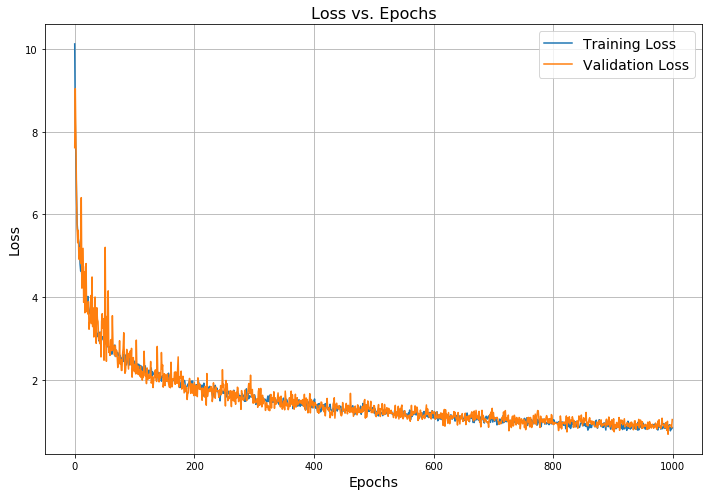

In [11]:
# Visualize the training process  
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(train_loss, label='Training Loss')
ax.plot(val_loss, label='Validation Loss')
ax.set_title('Loss vs. Epochs', fontsize=16)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(fontsize=14)
ax.grid(True)
plt.tight_layout()
plt.show()